In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [16]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        #plt.imshow(image)
        #print(mask)
        mask_expanded = mask[:, :, np.newaxis]   # 마스크의 차원을 (797, 1024, 1)로 확장

        image_normalized = image / 255.0         # 이미지의 값 0~255을 0~1로 바꿈
        masked_image = image_normalized * mask_expanded     # 브로드캐스팅을 통해 이미지의 각 채널에 마스크를 곱
        
        plt.imshow(masked_image)
        #show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            #show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')       # on에서 바꿈

        # 이미지 파일로 저장
        # plt.savefig(f"masked_image_{i+1}.png", bbox_inches='tight', pad_inches=0)
        
        plt.show()

def process_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)
            image = np.array(image.convert("RGB"))

            # 이미지 설정
            predictor.set_image(image)

            # 예시 포인트와 라벨 설정
            center_y, center_x = image.shape[0] // 4, image.shape[1] // 4
            # input_point = np.array([[center_x, center_y]])  # (x, y) 형태로 설정
            input_box = np.array([center_x, center_y, center_x, center_y*3])    # 각 (x1,y1,x2,y2)
            input_label = np.array([1])

            # 마스크 예측
            masks, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )

            # 마스크를 시각화하고 저장
            show_masks(image, masks, scores, box_coords=input_box)
            save_masks(image, masks, scores, output_folder, filename)

def save_masks(image, masks, scores, output_folder, original_filename):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        black_background = np.zeros_like(image)
        mask_expanded = mask[:, :, np.newaxis]
        masked_image = np.where(mask_expanded, image, black_background)

        masked_image_pil = Image.fromarray(masked_image.astype(np.uint8))
        
        # 파일 이름 수정: 원본 파일 이름에 "_masked" 추가
        base_filename, ext = os.path.splitext(original_filename)
        output_filename = f"{base_filename}_masked_{i+1}.png"
        output_path = os.path.join(output_folder, output_filename)
        
        masked_image_pil.save(output_path)

def clear_gpu_memory():
    # 명시적으로 메모리에서 변수 삭제
    del sam2_model
    del predictor
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

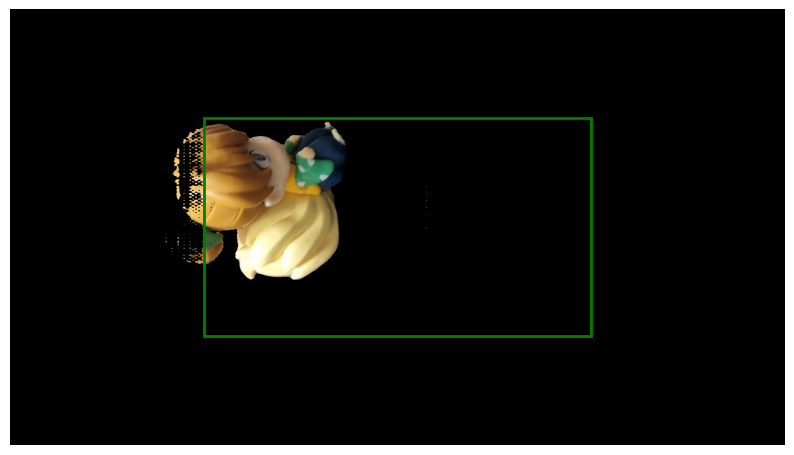

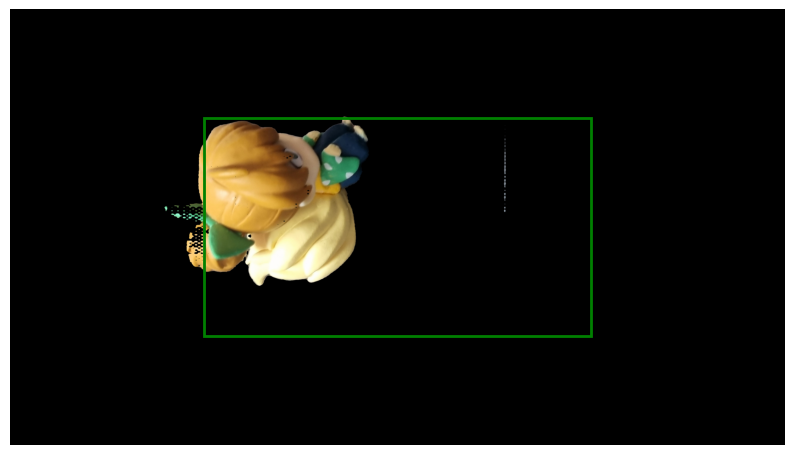

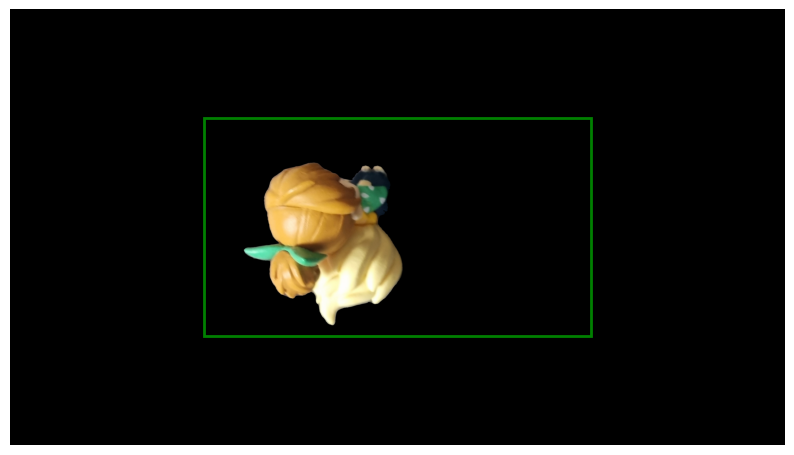

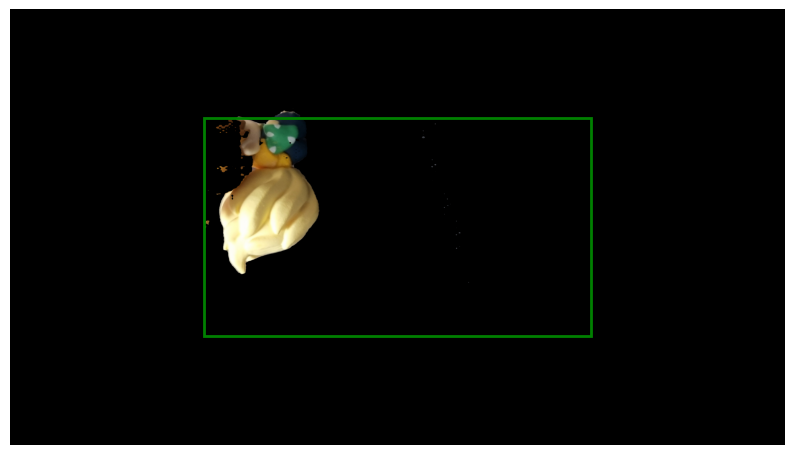

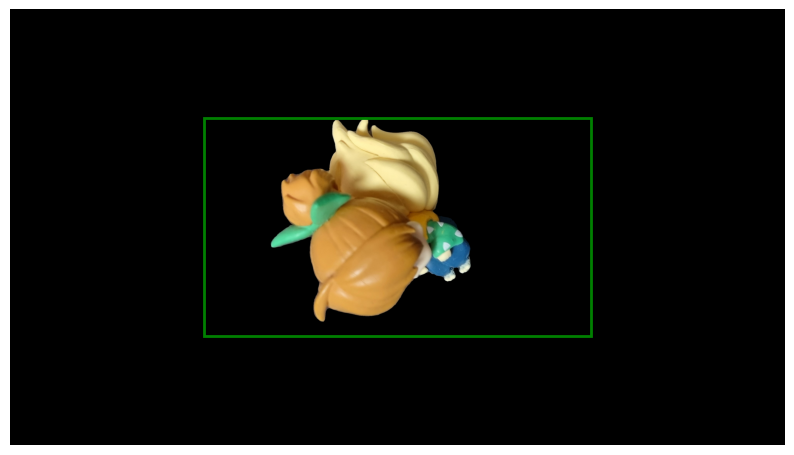

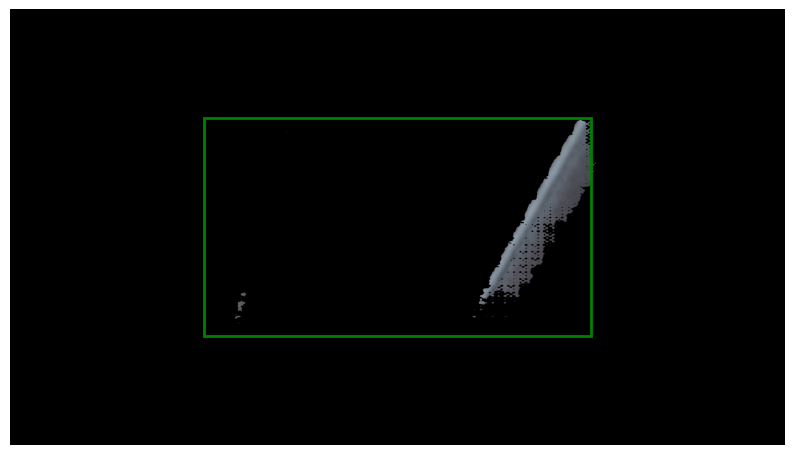

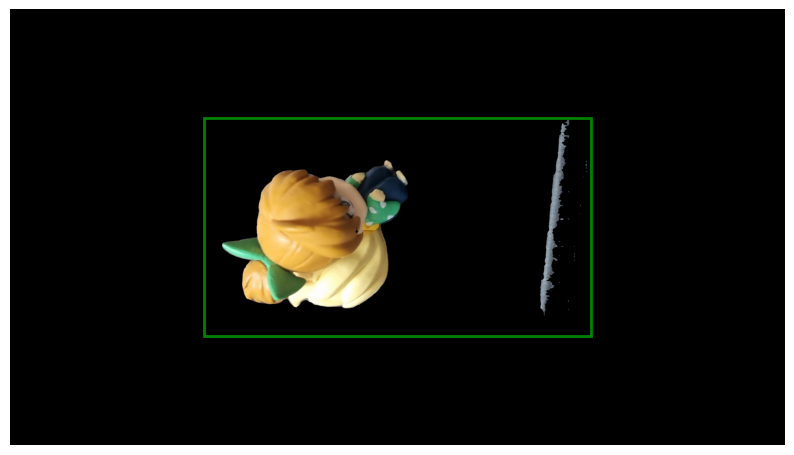

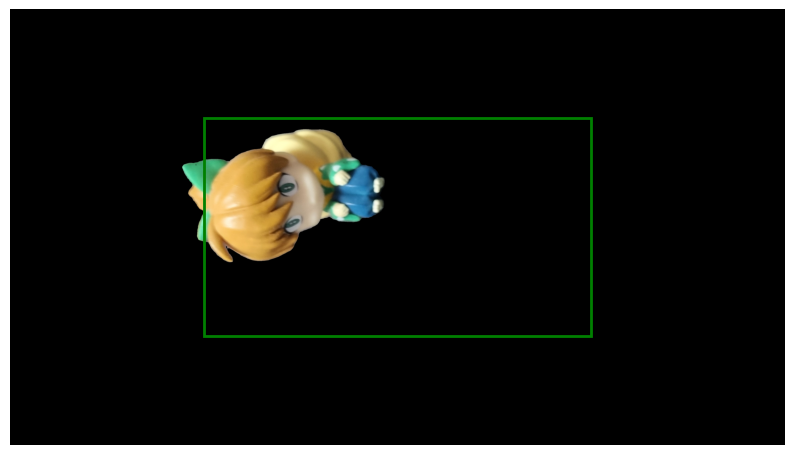

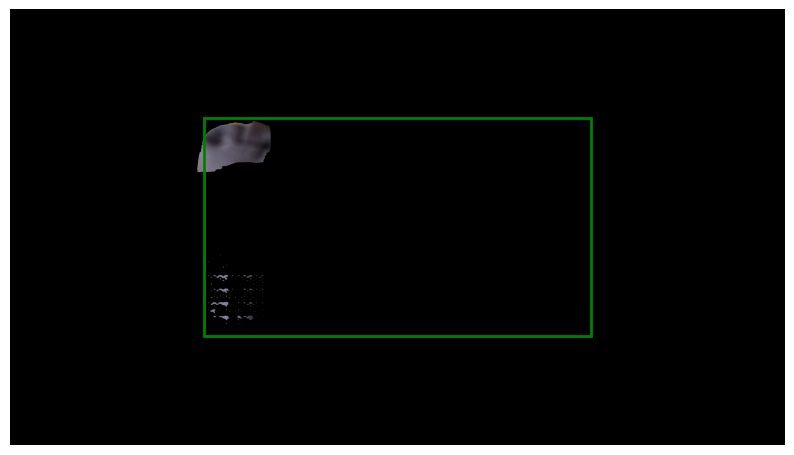

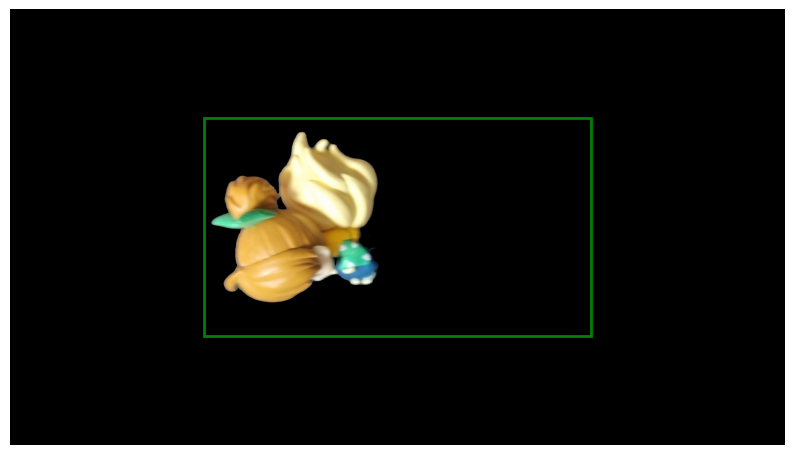

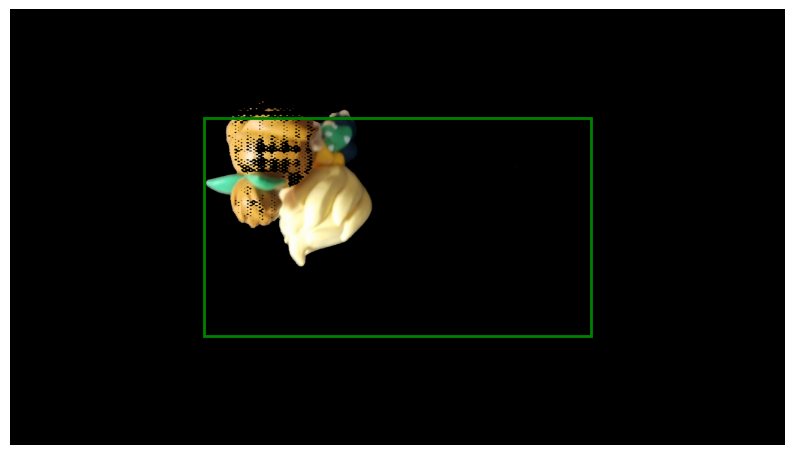

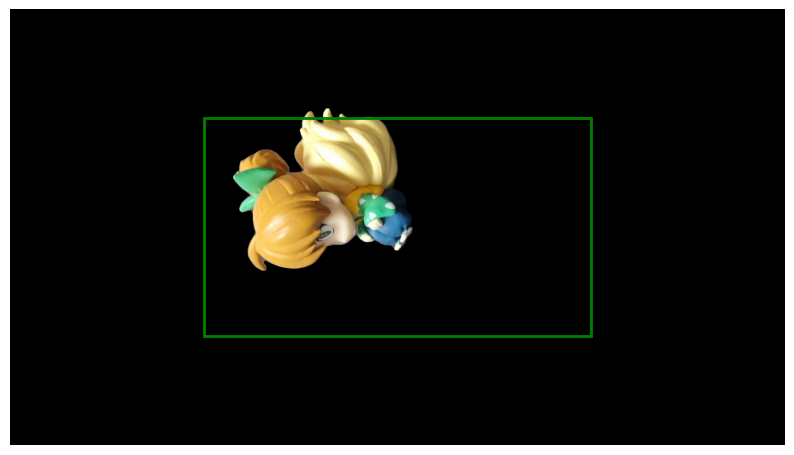

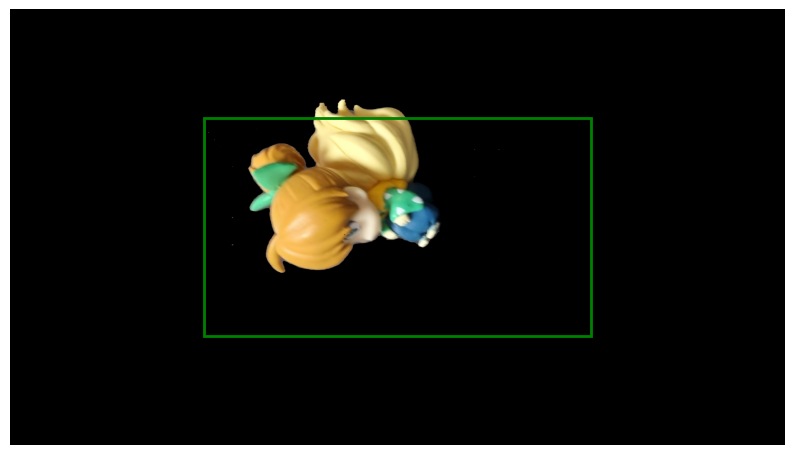

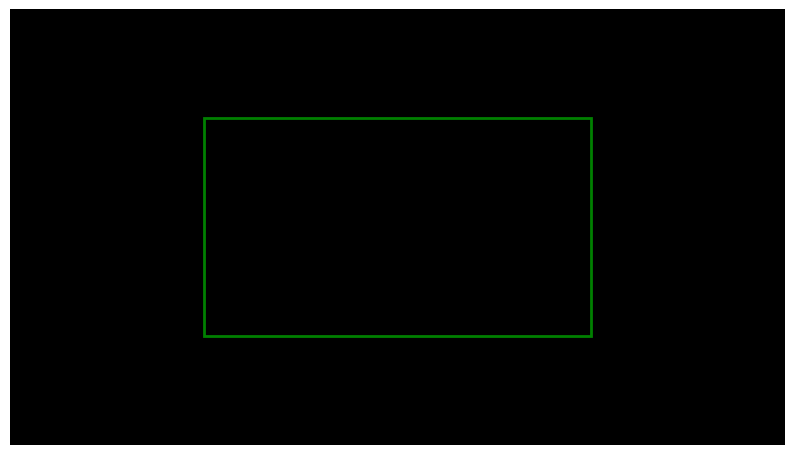

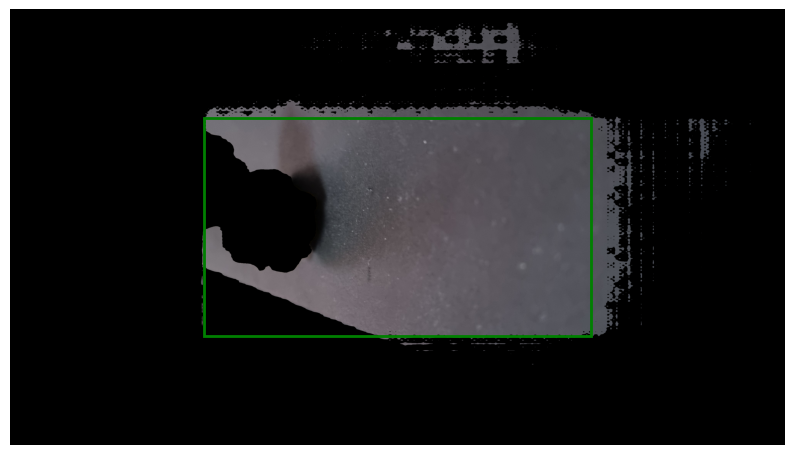

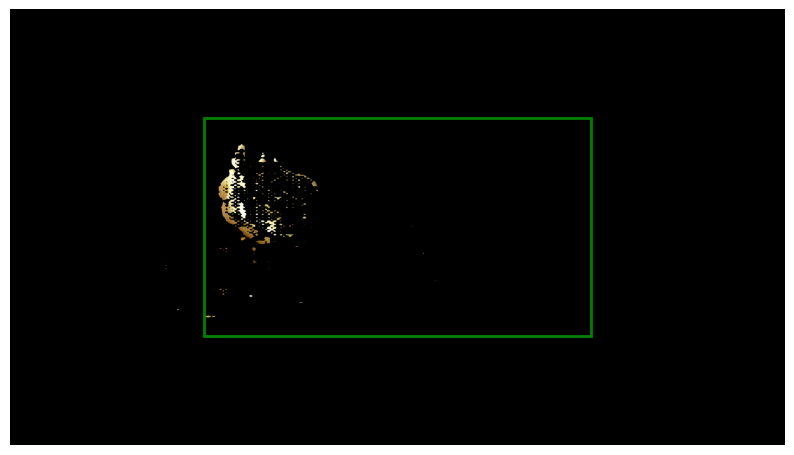

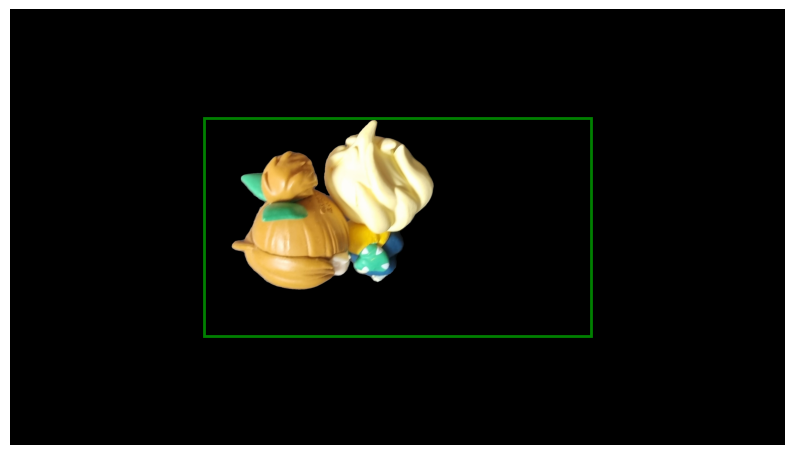

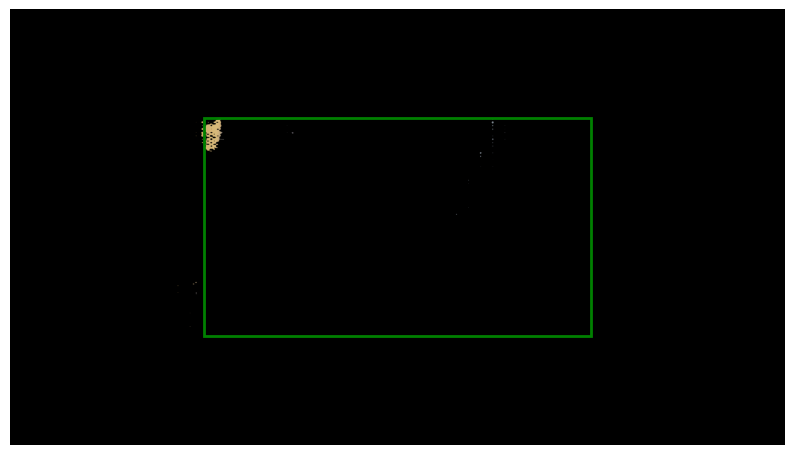

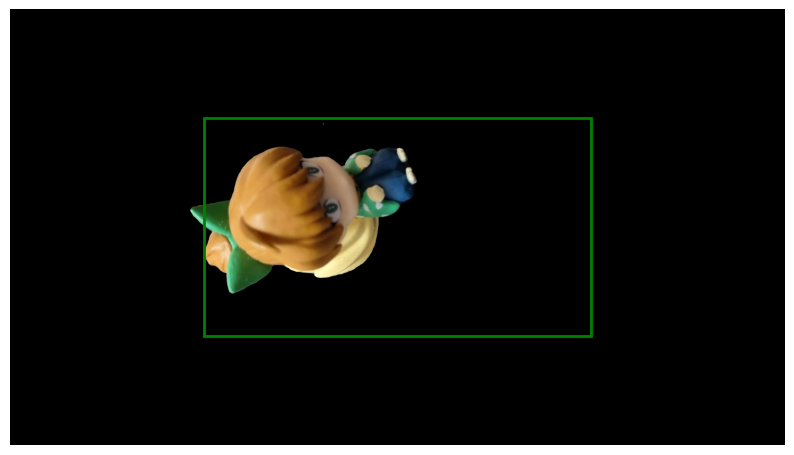

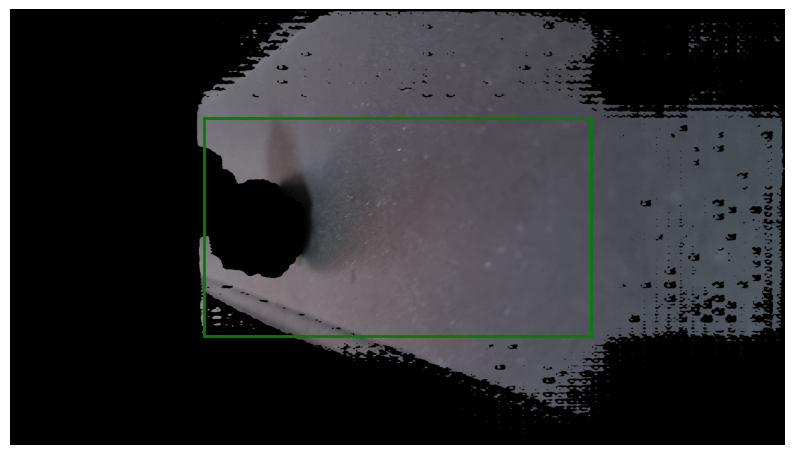

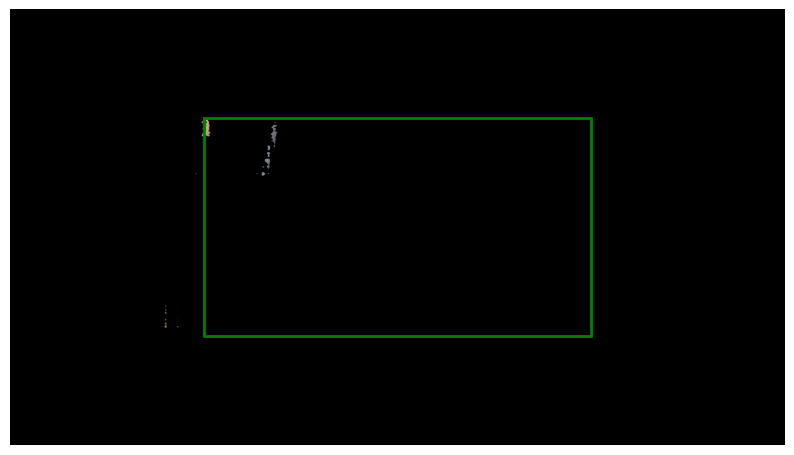

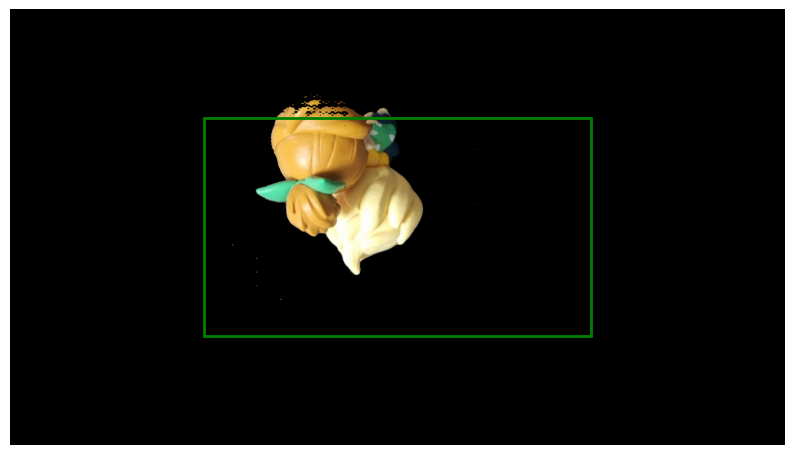

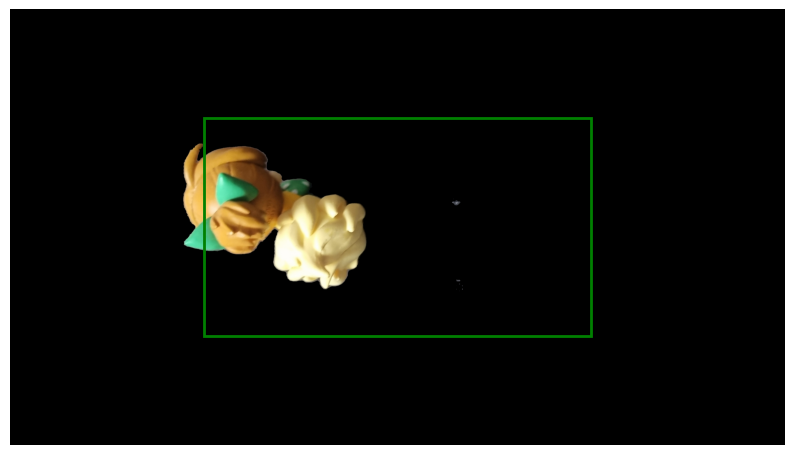

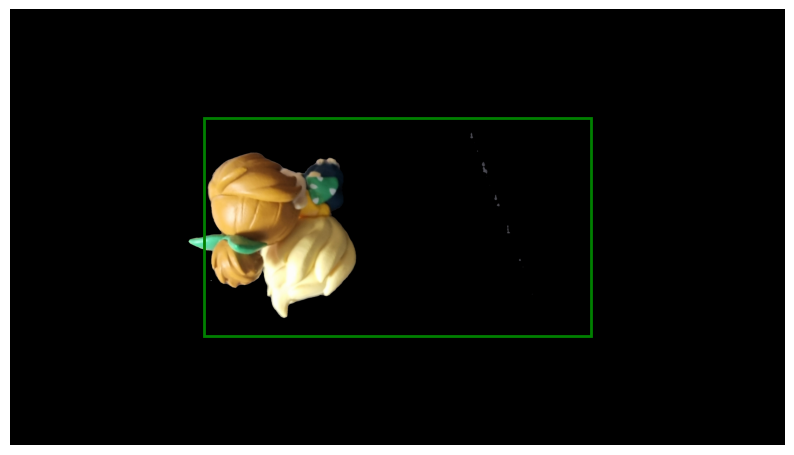

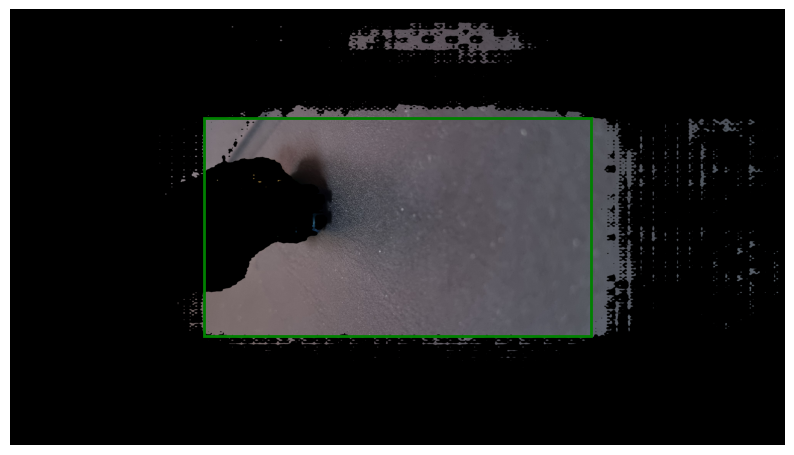

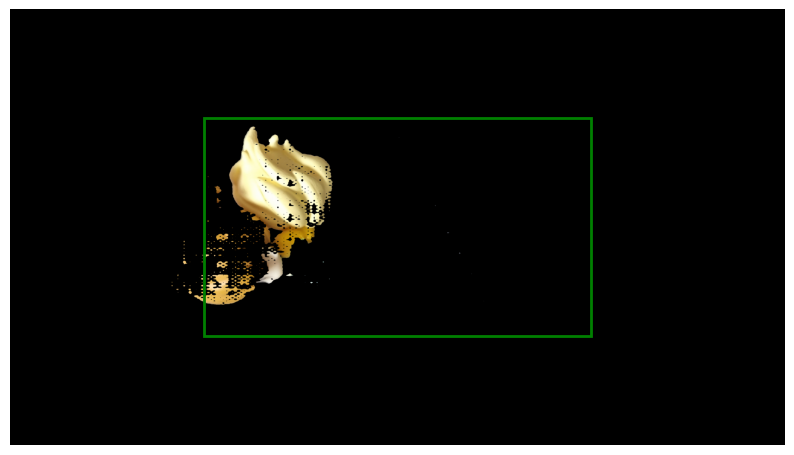

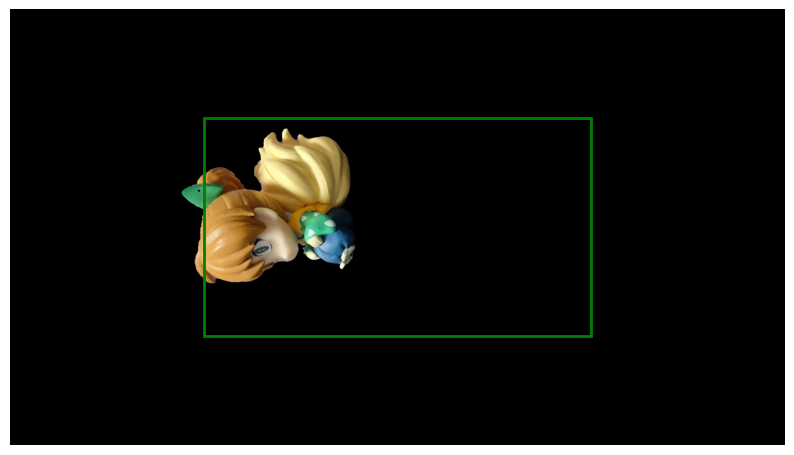

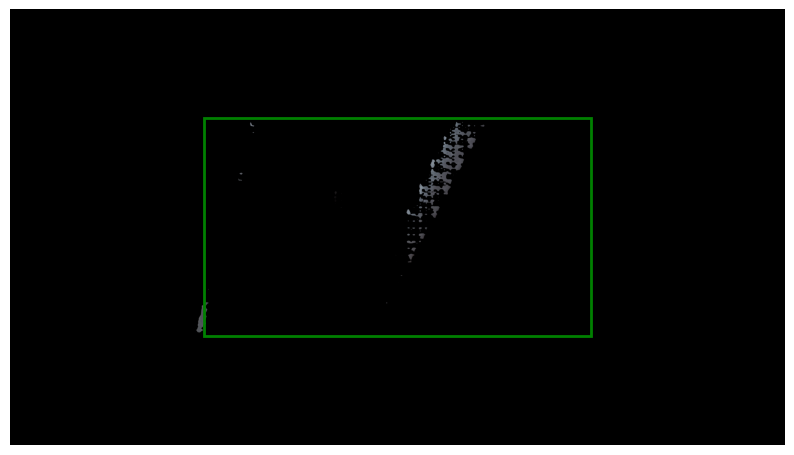

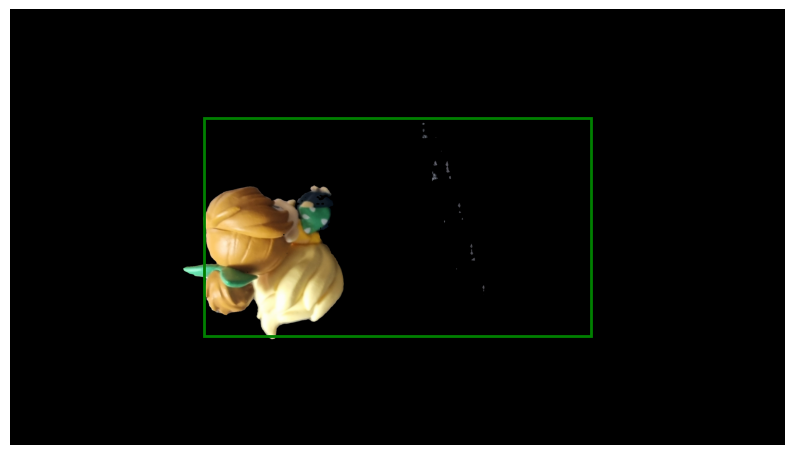

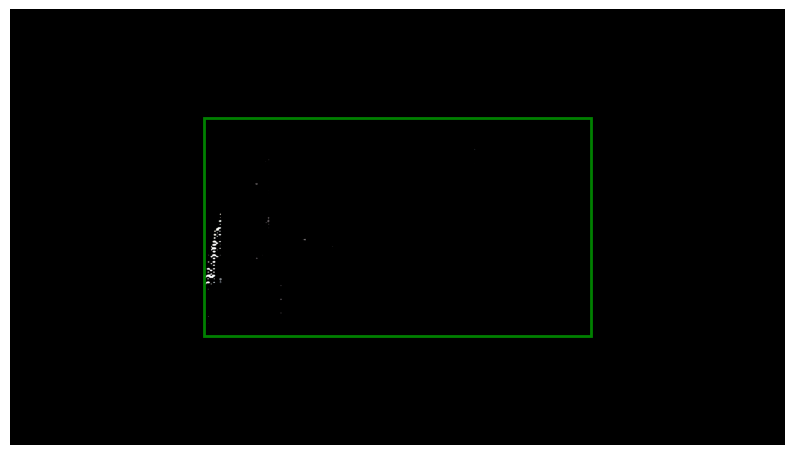

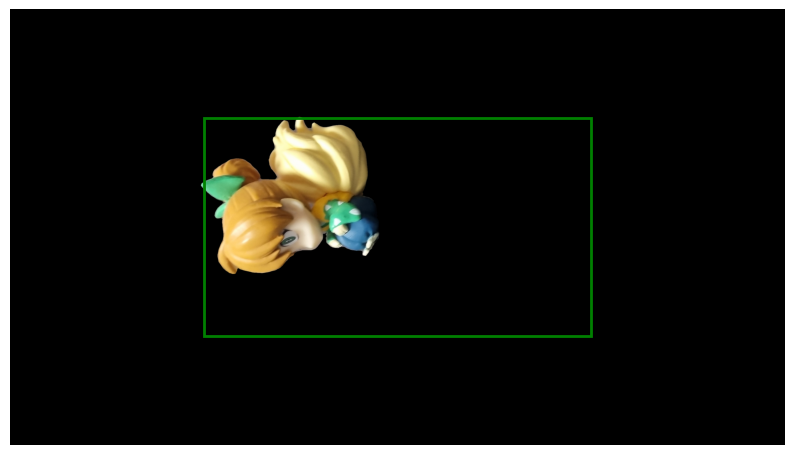

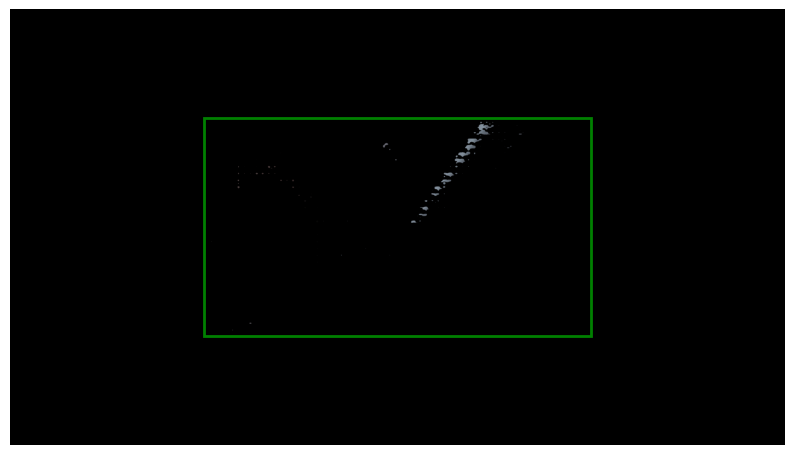

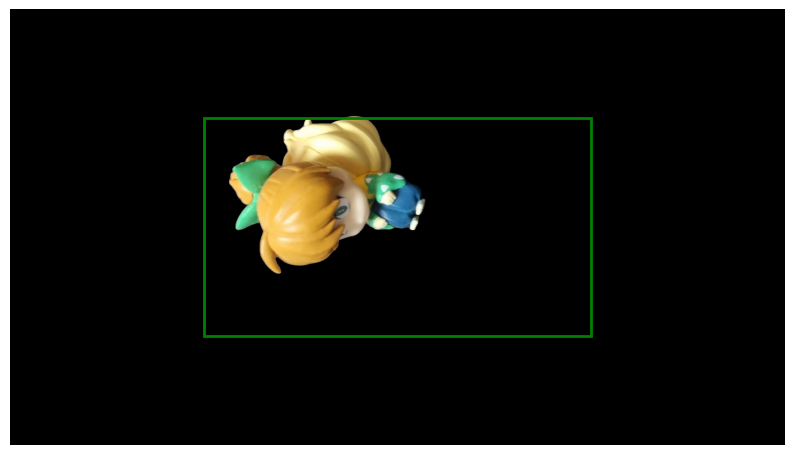

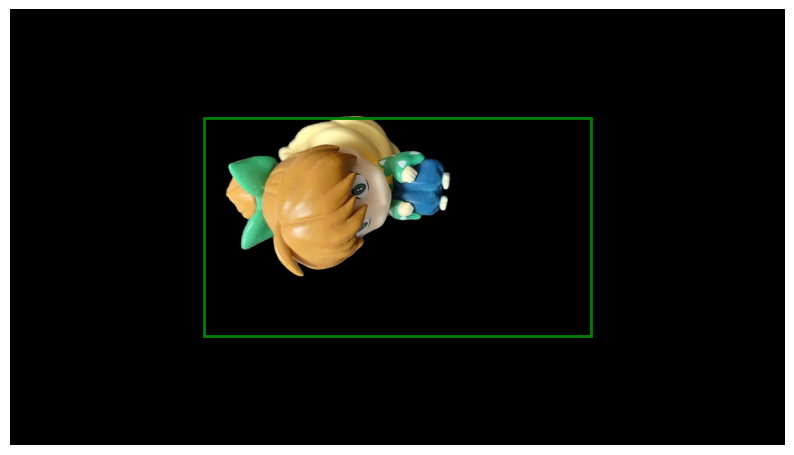

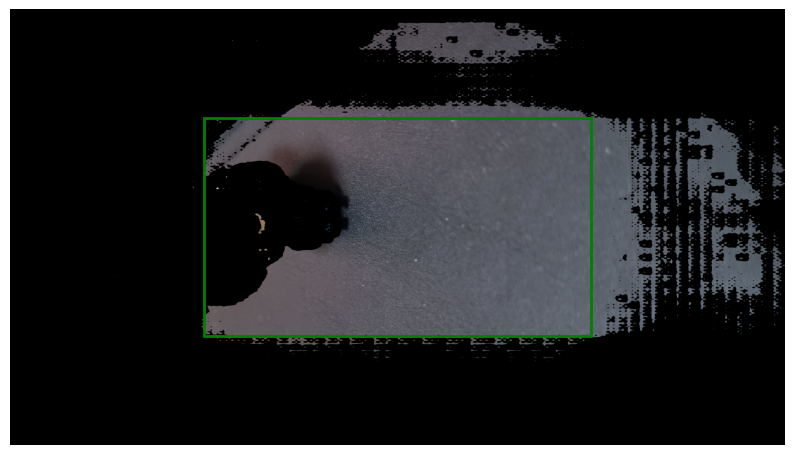

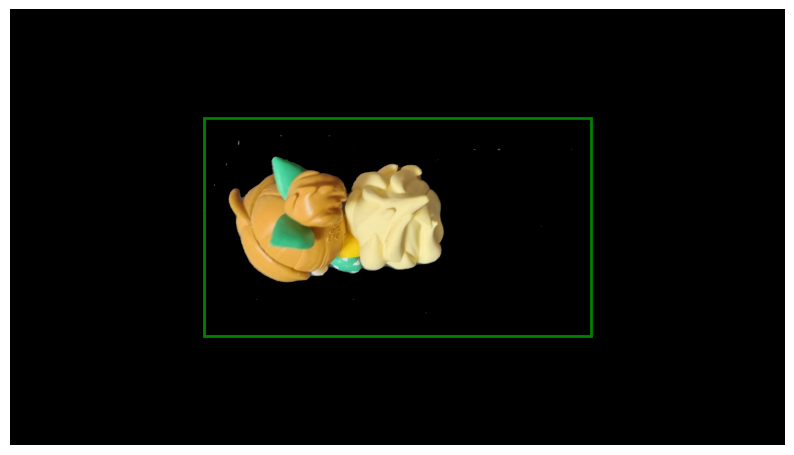

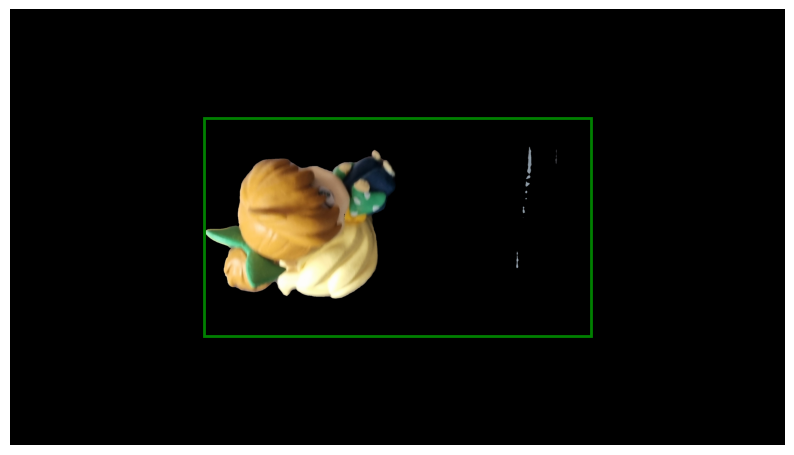

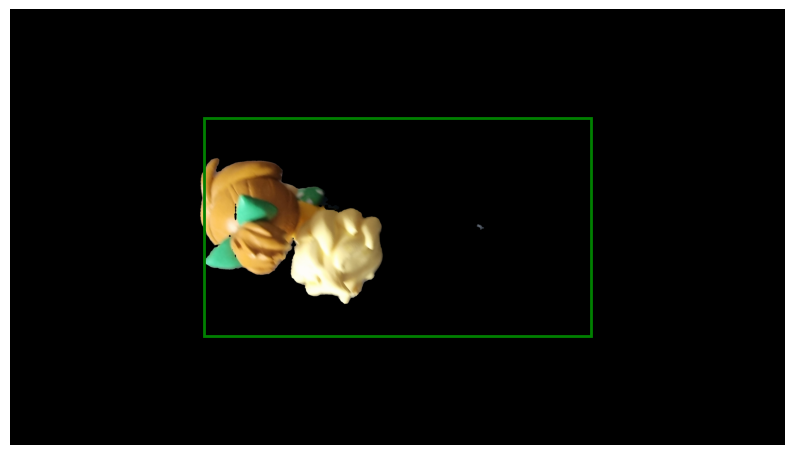

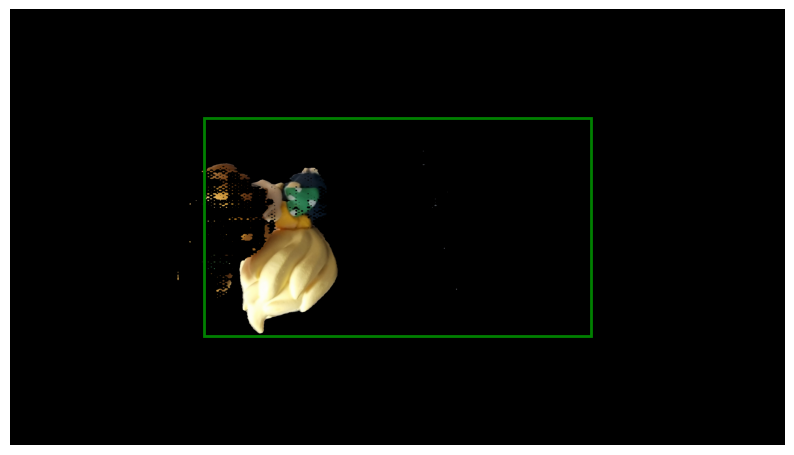

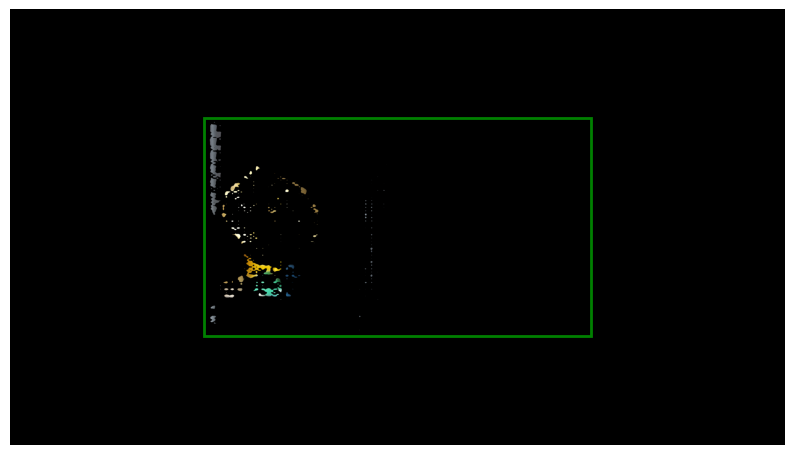

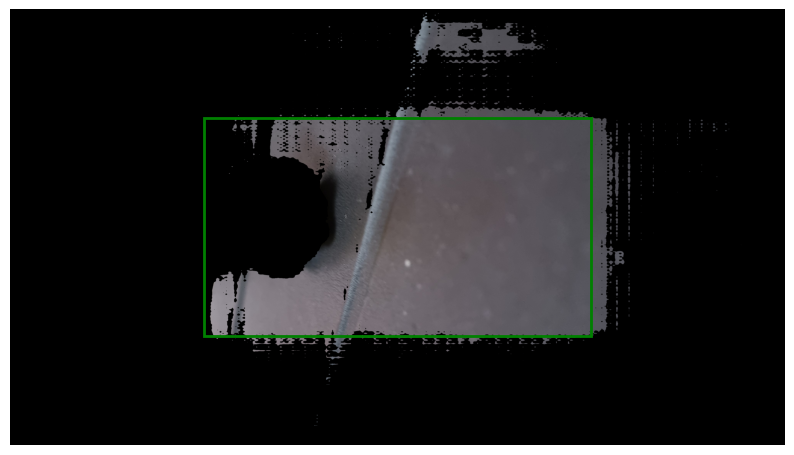

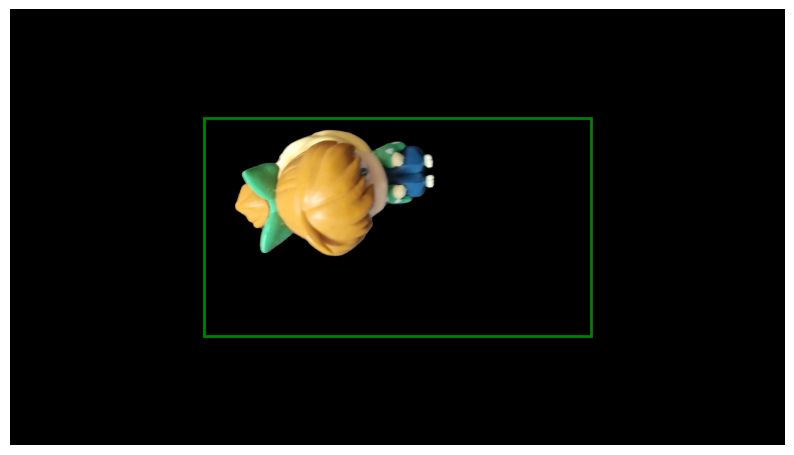

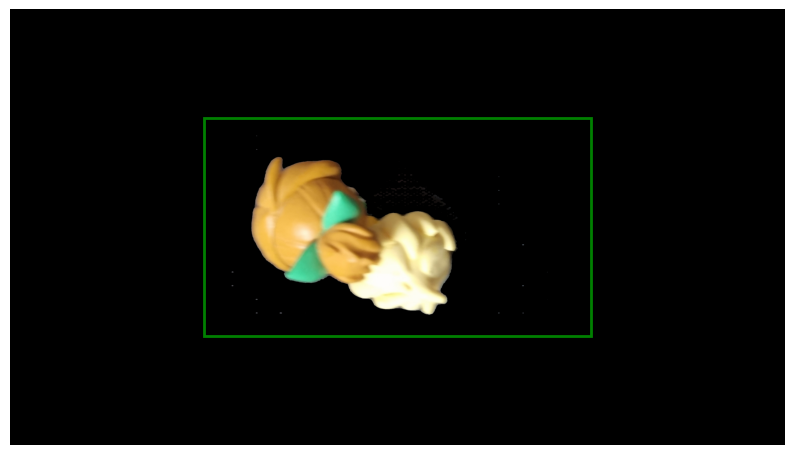

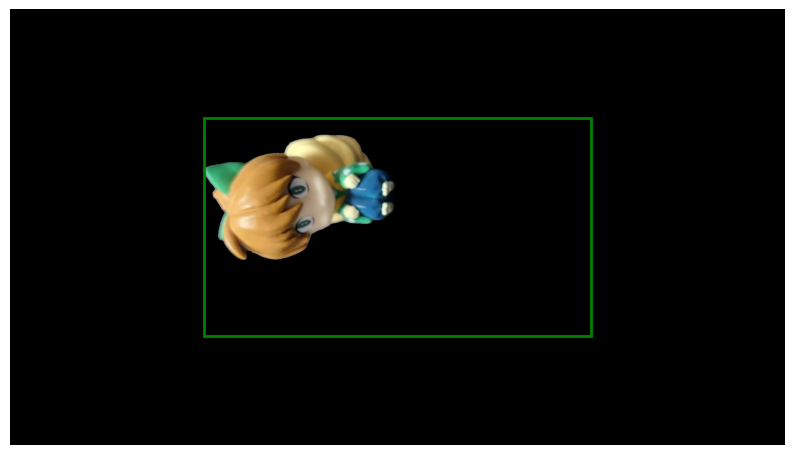

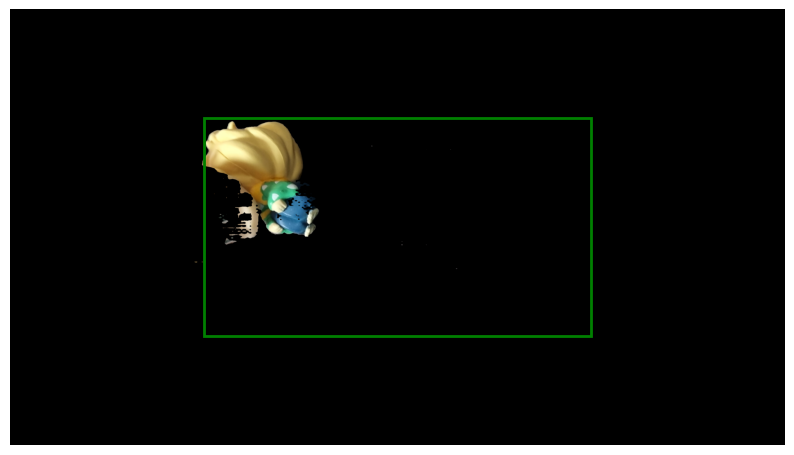

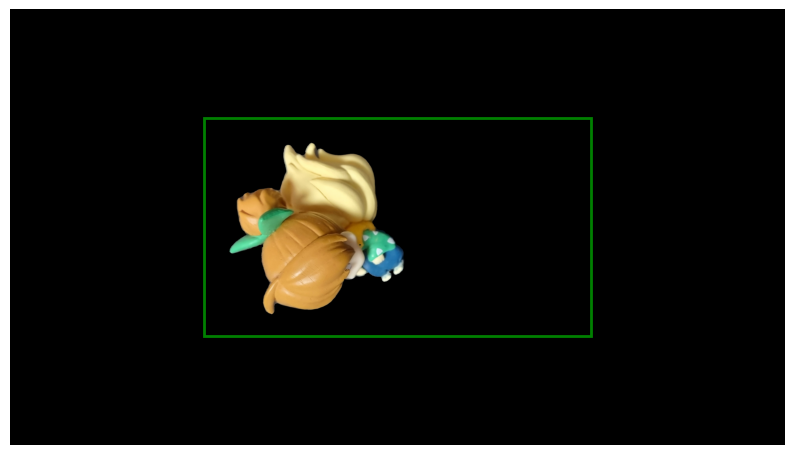

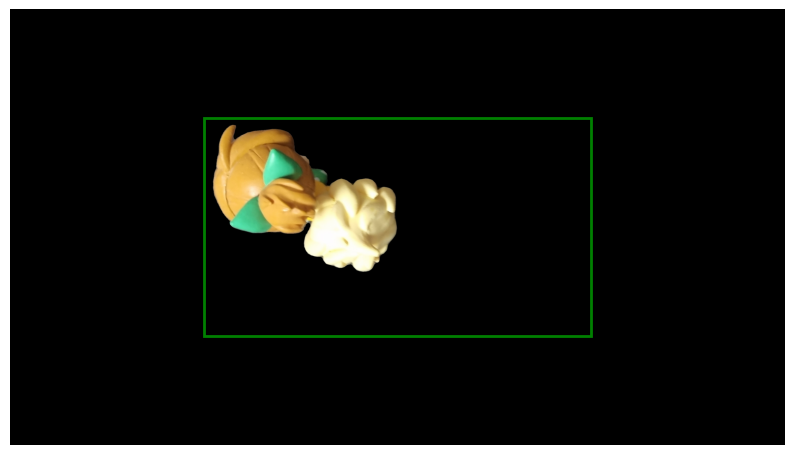

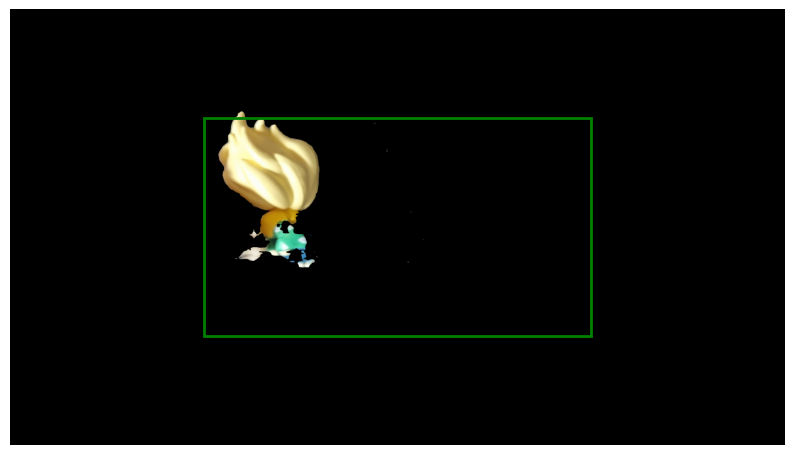

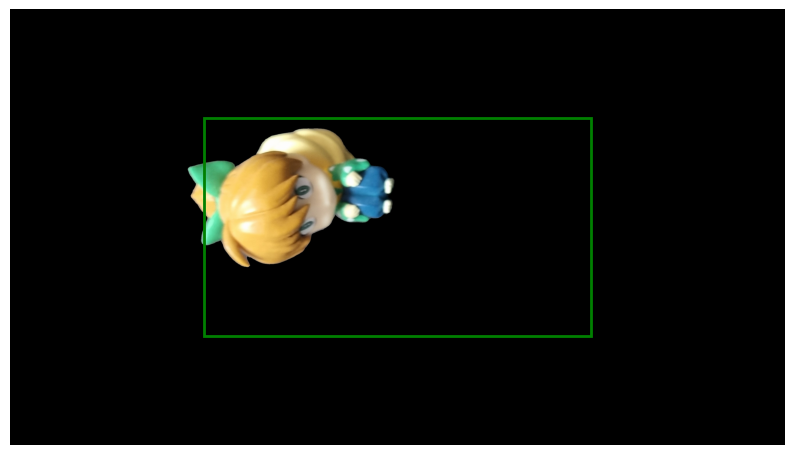

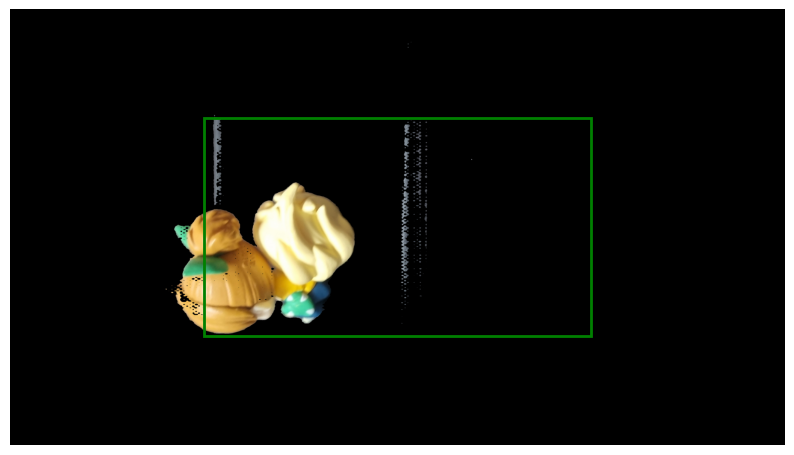

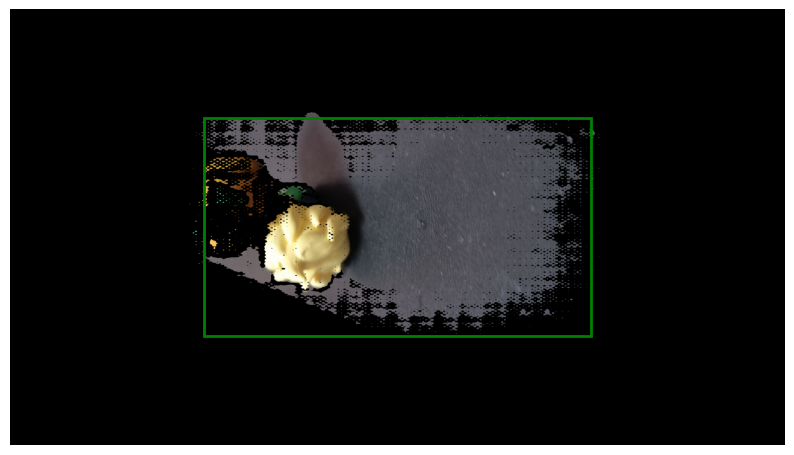

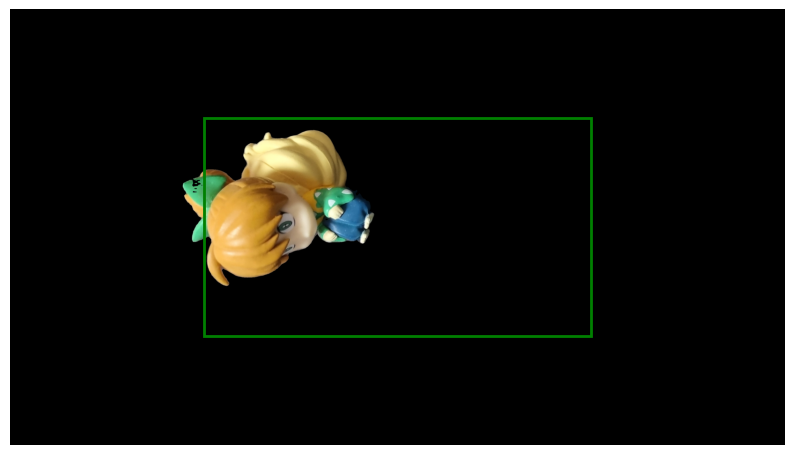

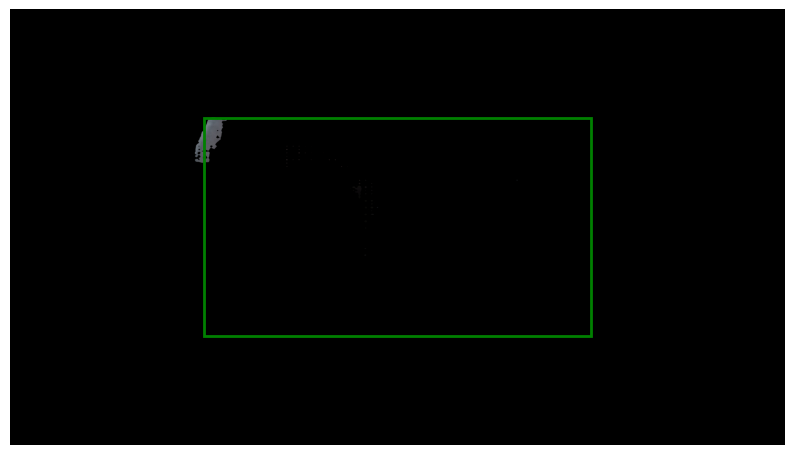

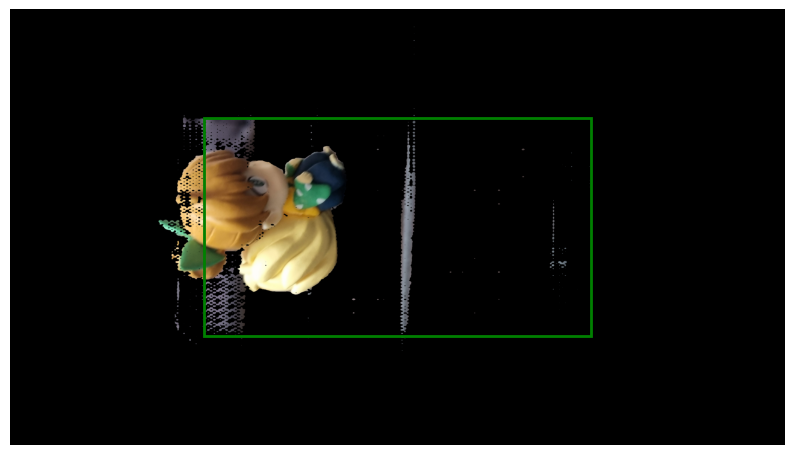

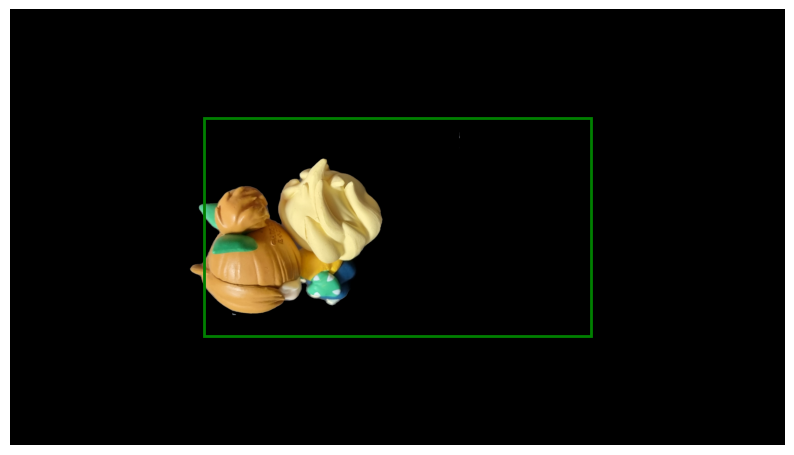

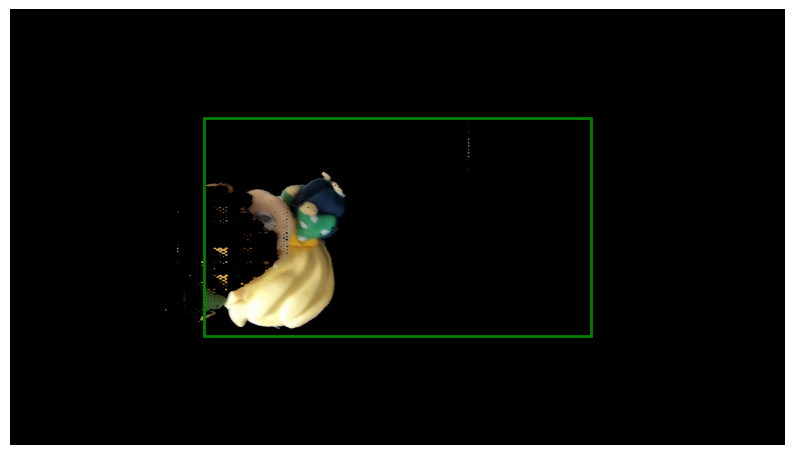

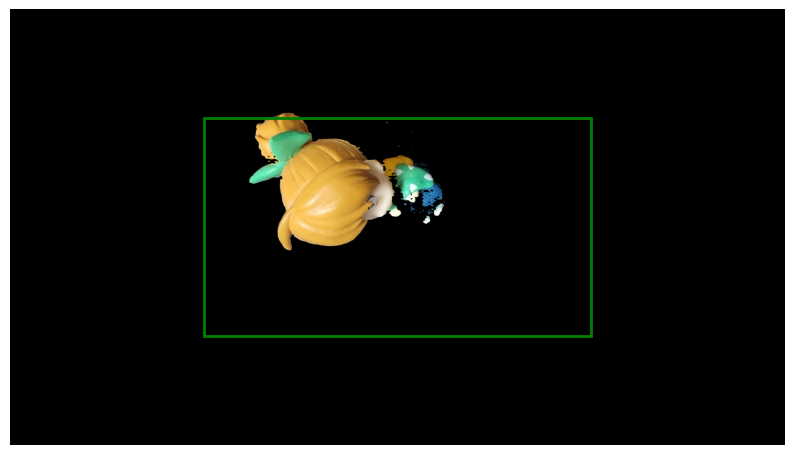

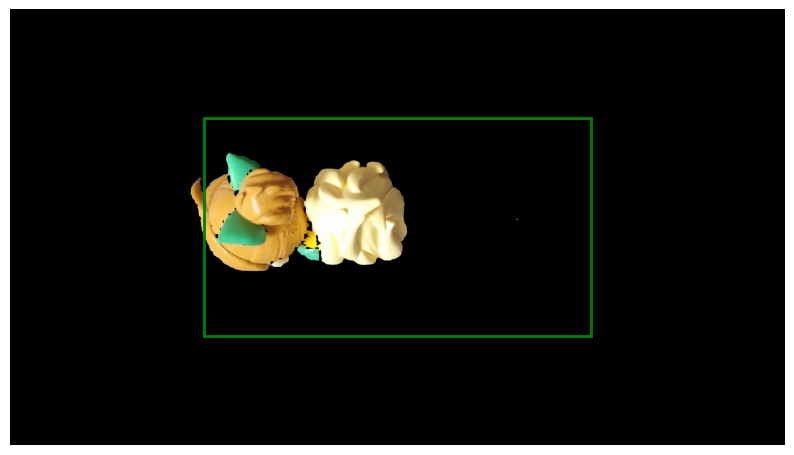

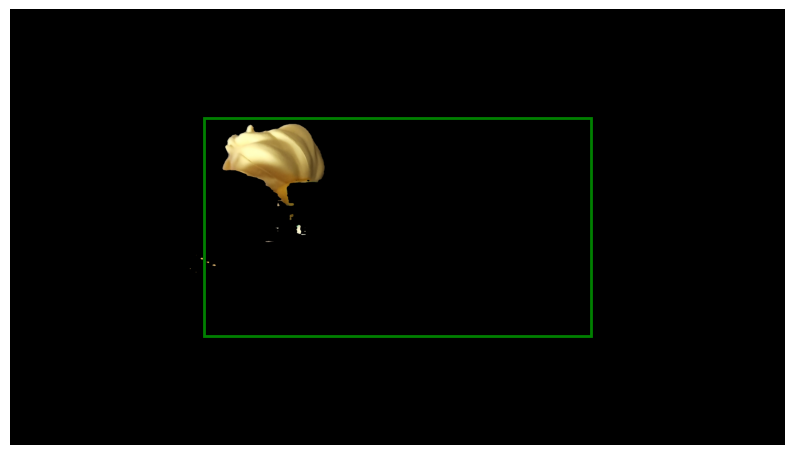

In [17]:
# 모델 로드 및 predictor 초기화
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

input_folder = 'images/sippo/input'
output_folder = 'images/sippo/output'
process_images_in_folder(input_folder, output_folder)

In [18]:
clear_gpu_memory()

UnboundLocalError: local variable 'sam2_model' referenced before assignment

In [11]:
# 8.12 여기부터 진행할 것

In [12]:
# 8.12 여기부터 진행할 것

In [75]:
# 8.12 여기부터 진행할 것